In [37]:
import pyodbc
import pandas as pd
import config as cfg

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [39]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
cnxn = pyodbc.connect( 'DRIVER={ODBC Driver 13 for SQL Server};SERVER=' + cfg.mssql['server'] + ';DATABASE=' 
                      + cfg.mssql['database'] + ';UID=' + cfg.mssql['username'] + ';PWD=' + cfg.mssql['password'] )

In [41]:
query = "SELECT * FROM BankSampleView;"
data = pd.read_sql(query, cnxn, index_col='BankID')
data.head()

,UniqueNum,Name,Address1,Address2,City,State,Zip,Deposit,Lat,Lng,...,ClosestPSDistance,MeanPSDistance,PSCount,Take,PDistance,Officers1000,FFLCount,Target,Population,CrimeRate1000
BankID,,,,,,,,,,,,,,,,,,,,,
1,511427,"Post Oak Bank, N.A.","1302 West Davis, Suite A",,Conroe,TX,77304,33279000,30.316460,-95.473317,...,0.764175,4.243279,3,16639,0.623582,2.358309,23,0,71111.0,34.51
2,257051,Compass Bank,"1703 West 5th Street, Suite 100",,Austin,TX,78703,702440000,30.274786,-97.765543,...,1.377339,3.285068,4,351220,0.562266,2.748199,34,0,956911.0,39.21
3,462675,"Wells Fargo Bank, National Association",2000 North Collins Street,,Arlington,TX,76011,101531000,32.766062,-97.097628,...,2.122295,6.157955,9,50765,0.487771,1.480947,41,0,392666.0,37.15
4,33042,Compass Bank,12649 Memorial Drive,,Houston,TX,77024,58403000,29.766799,-95.558093,...,2.919572,5.850609,5,29201,0.408043,4.075323,47,0,2334348.0,53.76
5,10549,First National Bank of Omaha,4500 Preston Road,,Frisco,TX,75034,82041000,33.116476,-96.804916,...,2.530443,6.394007,5,41020,0.446956,1.360801,33,0,162917.0,15.51


In [42]:
data.columns

Index(['UniqueNum', 'Name', 'Address1', 'Address2', 'City', 'State', 'Zip',
       'Deposit', 'Lat', 'Lng', 'ClosestStationID', 'ClosestPSDistance',
       'MeanPSDistance', 'PSCount', 'Take', 'PDistance', 'Officers1000',
       'FFLCount', 'Target', 'Population', 'CrimeRate1000'],
      dtype='object')

In [43]:
data.shape

(651, 21)

## Data Prep

In [44]:
data2 = pd.DataFrame(index=data.index.copy())

In [45]:
data2 = data[['Name', 'City', 'Deposit', 'ClosestPSDistance',
       'MeanPSDistance', 'PSCount', 'Take', 'PDistance', 'Officers1000',
       'FFLCount', 'Target', 'Population', 'CrimeRate1000' ]]

In [46]:
data2['CrimeRate1000'].mean()

36.34787499999993

In [47]:
data2['Population'].mean()

604486.4214285715

In [48]:
data2.isnull().sum()

Name                  0
City                  0
Deposit               0
ClosestPSDistance     0
MeanPSDistance        0
PSCount               0
Take                  0
PDistance             0
Officers1000          0
FFLCount              0
Target                0
Population           91
CrimeRate1000        91
dtype: int64

In [49]:
values = {'CrimeRate1000': data2['CrimeRate1000'].mean(), 'Population': data2['Population'].mean()}
data2.fillna(value=values, inplace=True)
#data2.dropna(axis=0, inplace=True)
data2.shape

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(651, 13)

In [50]:
# Map target class 1 - 5 (70% success rate and up) to 1 and the rest to 0 
data2['target_bin'] = data2.Target.map({ 0:0, 1:1, 2:1, 3:1, 4:1, 5:1 })

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [51]:
data2.target_bin[data2.target_bin != 0].sum() #total target 

124

## Correlation

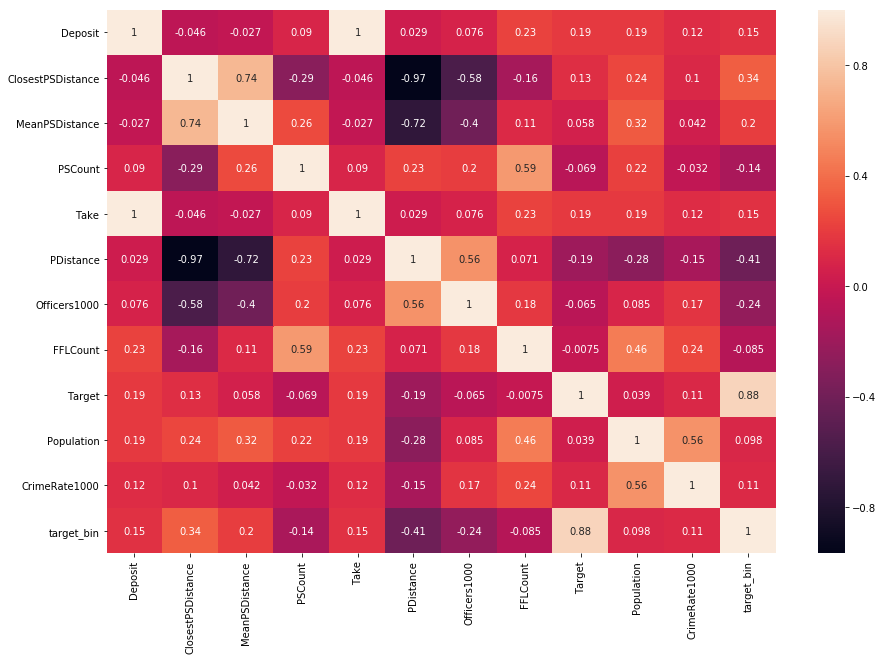

In [52]:
plt.figure(figsize = (15,10))
sns.heatmap(data2.corr(), annot=True)

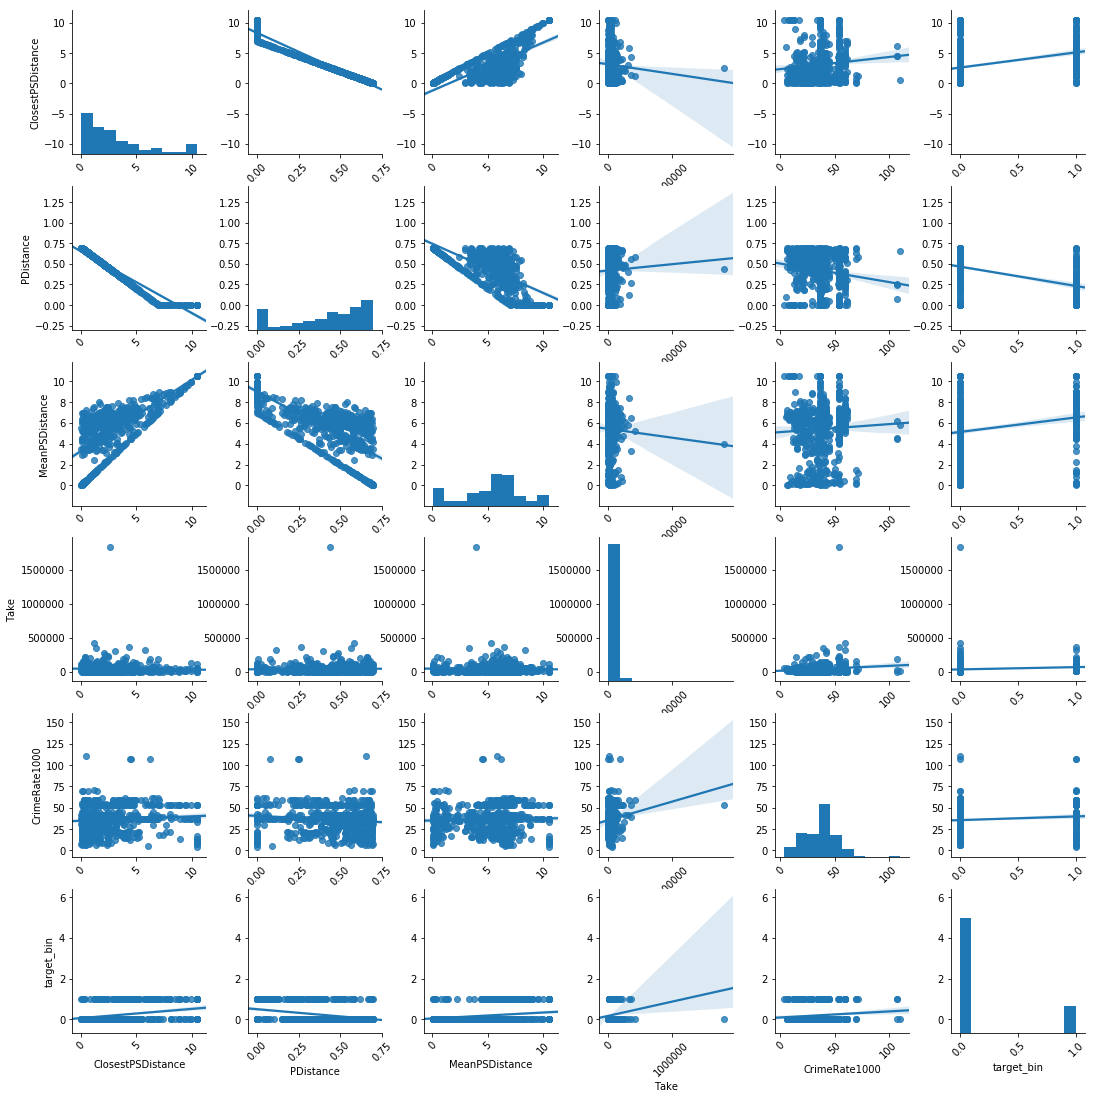

In [53]:
#Distance, P(Caught by Distance), Target correlation
g = sns.pairplot(data2[['ClosestPSDistance',  'PDistance', 'MeanPSDistance', 'Take', 'CrimeRate1000', 'target_bin']], diag_kind="hist", kind="reg")
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

## RandomForest with GridSearch for best Features, Max Depth and Min Leaf

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [59]:
feature_cols = ['ClosestPSDistance',
       'MeanPSDistance', 'PSCount', 'Take', 'PDistance', 'Officers1000',
       'FFLCount', 'Population', 'CrimeRate1000']
X = data2[feature_cols]
y = data2['target_bin']

0.971418130122
{'max_depth': 11}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


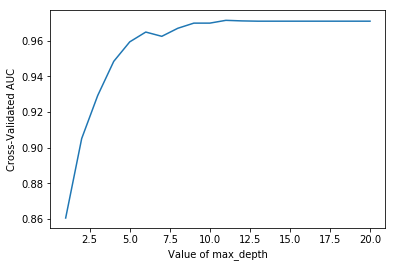

In [60]:
#Use RandomForest
rf = RandomForestClassifier(random_state=1)
max_depth_range = range(1, 21)
param_grid = dict(max_depth=list(max_depth_range))
grid = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc')
grid.fit(X, y)

grid_mean_scores = grid.cv_results_['mean_test_score']

# plot the results
plt.plot(max_depth_range, grid_mean_scores)
plt.xlabel('Value of max_depth')
plt.ylabel('Cross-Validated AUC')
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

In [61]:
pd.DataFrame({'feature':feature_cols, 'importance':grid.best_estimator_.feature_importances_}).sort_values(by=['importance'])

,feature,importance
2,PSCount,0.027600
5,Officers1000,0.043392
7,Population,0.045252
8,CrimeRate1000,0.060927
1,MeanPSDistance,0.073376
6,FFLCount,0.113258
4,PDistance,0.123751
0,ClosestPSDistance,0.199830
3,Take,0.312614


### Remove Features

0.970905075516
{'max_depth': 9}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


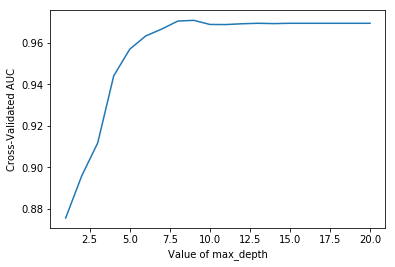

In [62]:
# Remove features: MeanPSDistance, PSCount
# Use the rest
feature_cols = ['ClosestPSDistance', 'Take', 'PDistance', 'Officers1000',
       'FFLCount', 'Population', 'CrimeRate1000']
X = data2[feature_cols]
y = data2['target_bin']

rf = RandomForestClassifier(random_state=1)
max_depth_range = range(1, 21)
param_grid = dict(max_depth=list(max_depth_range))
grid = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc')
grid.fit(X, y)

grid_mean_scores = grid.cv_results_['mean_test_score']

# plot the results
plt.plot(max_depth_range, grid_mean_scores)
plt.xlabel('Value of max_depth')
plt.ylabel('Cross-Validated AUC')
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

### Best Depth and Min Leaf

In [63]:
# search for best depth and min leaf
max_depth_range = range(1, 21)
leaf_range = range(1, 11)
param_grid = dict(max_depth=list(max_depth_range), min_samples_leaf=list(leaf_range))
grid = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc')
grid.fit(X, y)
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.974288653458
{'max_depth': 12, 'min_samples_leaf': 2}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


## Use the random_state and min_samples_leaf for a final model

In [64]:
rf2 = RandomForestClassifier(random_state=1, max_depth=12, min_samples_leaf=2)
rf2.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [66]:
#Check the model with prediction
y_pred = rf2.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.98159509202453987

In [68]:
from sklearn.tree import export_graphviz
idx = 0
for tree in rf2.estimators_:
    export_graphviz(tree, out_file='tree_banks_' + str(idx) + '.dot', feature_names=feature_cols)
    idx = idx + 1

In [69]:
! dot -Tpng tree_banks_1.dot -o tree_banks_1.png

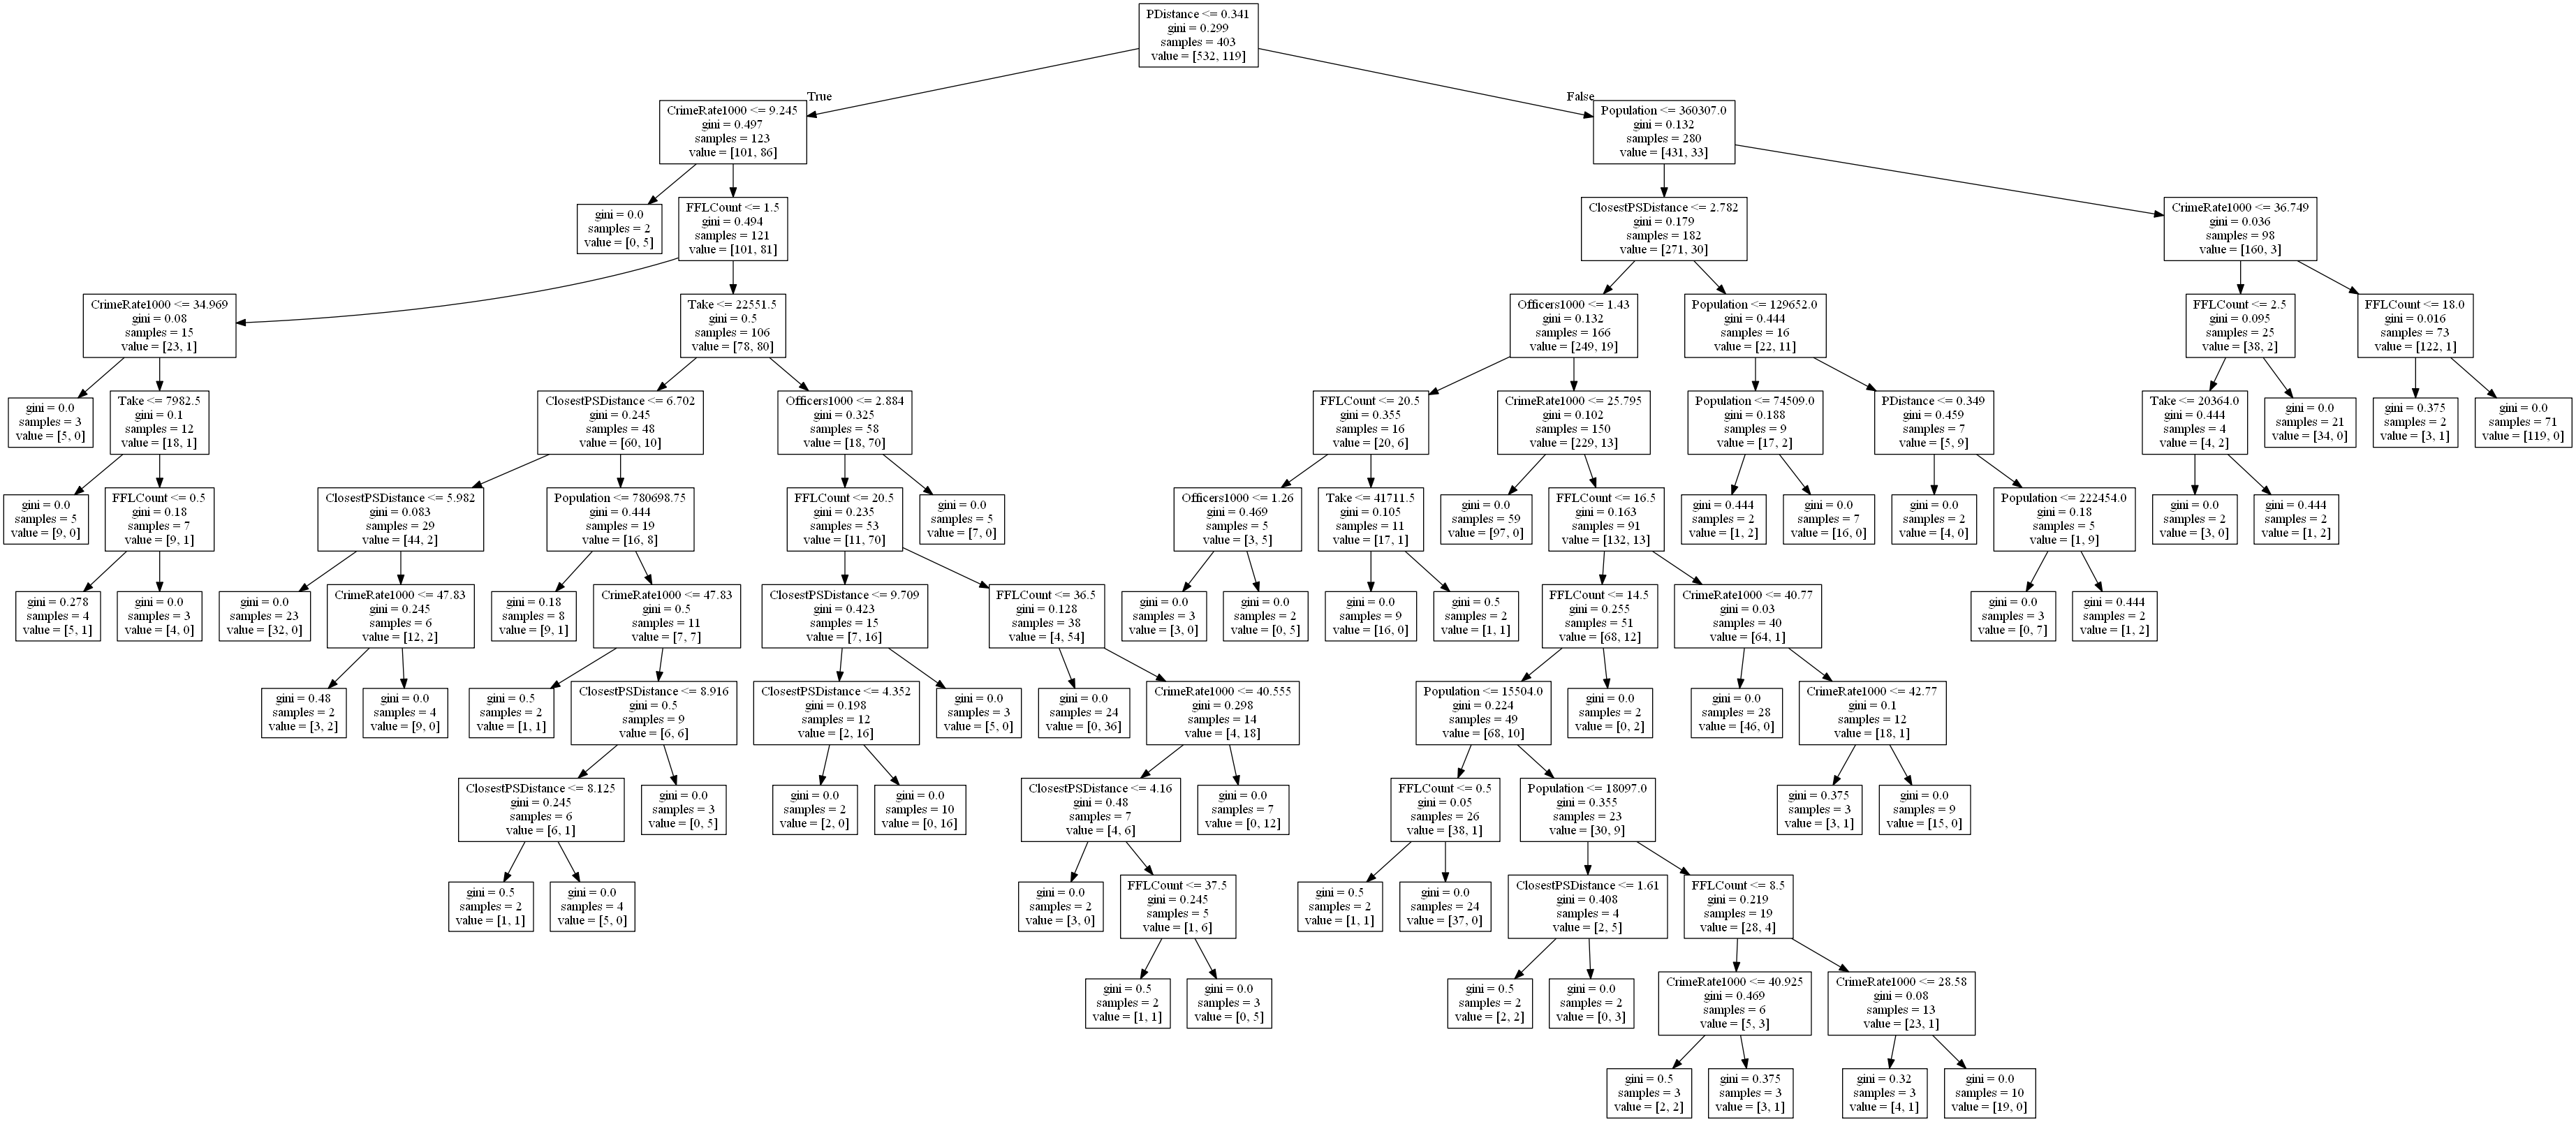

In [70]:
from IPython.display import Image
from IPython.display import display

display(Image('tree_banks_1.png'))

## Save Model to Pickle

In [71]:
try:
    import cPickle as pickle
except ImportError:
    import pickle

In [72]:
## Save the RandomForestClassifier model
out_s = open('targetbanks_randomforestclassifier.pkl', 'wb')
pickle.dump(rf2, out_s)
out_s.close()